# Sistemas de recomendación
### Carga de datos de Movie Lens

In [20]:
import pandas as pd

In [21]:
import mysql.connector as sql
db_connection = sql.connect(host='dcloudsoft.com', database='dcloudso_ecommerce', user='dcloudso_prueba', password='123456789')
df = pd.read_sql_query('SELECT id_usuario,id_producto,calificacion,comentarios.fecha from productos,comentarios where id_producto = productos.id', con=db_connection)

In [22]:
type(df)

pandas.core.frame.DataFrame

In [23]:
df.head()

,id_usuario,id_producto,calificacion,fecha
0,21,26,1.0,2018-06-08 16:17:00
1,21,36,4.0,2018-06-08 16:25:10
2,21,45,3.0,2018-06-08 16:25:38
3,21,43,4.5,2018-06-08 16:26:01
4,22,4,4.5,2018-06-08 16:42:16


In [7]:
df.shape

(19, 4)

In [8]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]

In [9]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,21,26,1.0,2018-06-08 16:17:00
1,21,36,4.0,2018-06-08 16:25:10
2,21,45,3.0,2018-06-08 16:25:38
3,21,43,4.5,2018-06-08 16:26:01
4,22,4,4.5,2018-06-08 16:42:16


### Análisis exploratorio de los ítems

In [10]:
import matplotlib.pyplot as plt

(array([1., 1., 0., 1., 0., 2., 1., 5., 5., 3.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

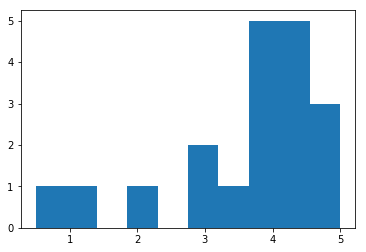

In [11]:
plt.hist(df.Rating)

In [12]:
df.groupby(["Rating"])["UserID"].count()

Rating
0.5    1
1.0    1
2.0    1
3.0    2
3.5    1
4.0    5
4.5    5
5.0    3
Name: UserID, dtype: int64

(array([9., 0., 0., 0., 0., 2., 0., 0., 0., 2.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

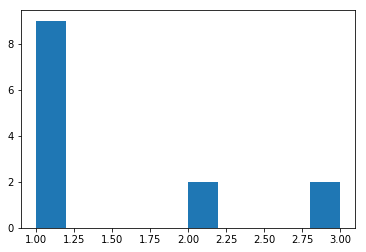

In [13]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

### Representación en forma matricial

In [14]:
import numpy as np

In [15]:
n_users = df.UserID.unique().shape[0]
n_users

3

In [16]:
n_items = df.ItemID.unique().shape[0]
n_items

13

In [17]:
ratings = np.zeros((n_users, n_items))

In [18]:
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

IndexError: index 20 is out of bounds for axis 0 with size 3

In [ ]:
type(ratings)

In [ ]:
ratings.shape

In [19]:
ratings

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


### Crear conjuntos de entrenamiento y validación

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [ ]:
ratings_train.shape

In [ ]:
ratings_test.shape

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [ ]:
import numpy as np
import sklearn

In [ ]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)

In [ ]:
type(sim_matrix)

In [ ]:
sim_matrix.shape

In [ ]:
sim_matrix

In [ ]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [ ]:
users_predictions

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [ ]:
get_mse(users_predictions, ratings_train)

In [ ]:
get_mse(users_predictions, ratings_test)

## Filtro colaborativo basado en los KNN

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
k = 5

In [ ]:
neighbors = NearestNeighbors(k, 'cosine')

In [ ]:
neighbors.fit(ratings_train)

In [ ]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [ ]:
top_k_distances.shape

In [ ]:
top_k_distances[0]

In [ ]:
top_k_users.shape

In [ ]:
top_k_users[0]

In [ ]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T

In [ ]:
users_predicts_k.shape

In [ ]:
users_predicts_k

In [ ]:
get_mse(users_predicts_k, ratings_train)

In [ ]:
get_mse(users_predicts_k, ratings_test)

## Filtro colaborativo basado en Items

In [ ]:
n_movies = ratings_train.shape[1]
n_movies

In [ ]:
neighbors = NearestNeighbors(n_movies, 'cosine')

In [ ]:
neighbors.fit(ratings_train.T)

In [ ]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [ ]:
top_k_distances.shape

In [ ]:
top_k_distances

In [ ]:
top_k_items.shape

In [ ]:
top_k_items

In [ ]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

In [ ]:
item_preds.shape

In [ ]:
item_preds

In [ ]:
get_mse(item_preds, ratings_train)

In [ ]:
get_mse(item_preds, ratings_test)

### Filtrado colaborativo basado en KNN

In [ ]:
k = 30
neighbors = NearestNeighbors(k, 'cosine')
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [ ]:
top_k_distances.shape

In [ ]:
top_k_items[0]

In [ ]:
top_k_distances[0]

In [ ]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

In [ ]:
get_mse(preds, ratings_train)

In [ ]:
get_mse(preds, ratings_test)

In [ ]:
preds.shape

In [ ]:
ratings_train.shape

In [ ]:
ratings_test.shape